In [8]:
import h5py
import numpy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from pandas import read_csv
import pandas as pd
from matplotlib.pyplot import subplots, axes, scatter, xticks
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from numpy import mean, array
import time
import random
import os
import pickle

In [6]:
#functions
#making embbeding df
#making embbeding df
def T5_match(reduced_embedding, long_df):
    reduced_file = h5py.File(reduced_embedding, "r")
    seq_embeddings = numpy.empty(1024)
    for item in long_df["Gene"]:
        #res = [key for key, val in indexes.items() if item  in val]
        array = numpy.asarray(reduced_file[item])
        #removinf nans
        array = numpy.nan_to_num(array, nan=0.0)
        seq_embeddings = numpy.vstack((seq_embeddings,array))
    seq_embeddings = seq_embeddings[1:]
    end_time = time.perf_counter()
    return seq_embeddings    
#matching embedding with Gene name in pooled embeddings


def substrate_match(long_df, descriptors, smiles):
    subs_descriptors = numpy.empty(167)
    for item in long_df['Substrate']:
        #print(item)
        index = smiles.index[smiles["Substrate"]==item][0]
        subs_descriptors = numpy.vstack((subs_descriptors, descriptors[index]))
    subs_descriptors = subs_descriptors[1:]
    return subs_descriptors
#function for substrate embedding generation
def substrate_descriptor(smiles):
    substrate_desc = numpy.empty(167)
    for item in smiles['SMILES']:
        #print(item.index())
        mol = Chem.MolFromSmiles(item)
        fp =  Chem.MACCSkeys.GenMACCSKeys(mol)
        array = numpy.zeros((0, ), dtype=numpy.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        substrate_desc = numpy.vstack((substrate_desc, array))

    substrate_desc = substrate_desc[1:]
    return substrate_desc

#make ML df for training
def makeMLset(input_df, fingerprints, adress):
    embeddings = dict()
    embeddings["ProtTrans"] = T5_match(adress, input_df)

    substrate_fp = dict()
    for key in fingerprints:
        substrate_fp[key] = substrate_match(input_df, fingerprints[key], smiles)
    X = dict()
    for item in substrate_fp:
        for item2 in embeddings:
            name = str(item) + '/' + str(item2)
            X[name] = numpy.hstack((embeddings[item2],  substrate_fp[item]))
    return(X)


#function to plot all 5 metrics from model_score function
def plot_model_score(score_model):
    metrics_list = ["Accuracy", "ROC AUC", "Precision", "Recall", "F1"]
    x = list(numpy.arange(len(metrics_list)))
    y = numpy.mean( score_model, axis = 1).flatten()
    err = numpy.std(score_model, axis = 1).flatten()
    fig, ax = subplots(figsize = (5,8))
    ax.bar(x, y, yerr = err)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_list, rotation=-90)
    fig.show()
    
#make ML df for training
def readExcel(input_set):
    training_dataset = pd.read_excel(input_set)
    training_dataset = pd.melt(training_dataset, id_vars = ["Gene"], var_name = "Substrate")
    training_dataset = training_dataset.dropna()
    return training_dataset

def makeTrainSet(adress, smiles, training_dataset):
    smiles = pd.read_csv(smiles, sep = ",")
    fingerprints = substrate_descriptor(smiles)
    embeddings = T5_match(adress, training_dataset)    
    substrate_fp = substrate_match(training_dataset, fingerprints, smiles)
    X = numpy.hstack((embeddings,  substrate_fp))
    return X

def testModel(input_excel, embedding, smiles):
    training_set = readExcel(input_excel)
    train_X = makeTrainSet(embedding,smiles, training_set)
    train_y = array(training_set["value"])
    sss = StratifiedShuffleSplit(random_state=12345, n_splits=100, test_size=0.3)
    score, roc_auc, precision, recall, f1 = list(), list(),list(),list(), list()
    
    for train_index, test_index in sss.split(train_X, train_y):
        X_s, y_s = train_X[train_index, :], train_y[train_index]
        new_obs_s, y_test_s = train_X[test_index, :], train_y[test_index]
        score_clf, roc_auc_clf, precision_clf, recall_clf, f1_clf = list(), list(),list(),list(), list()
        RANDOM_STATE = random.randint(0, 10000000)
        clf = MLPClassifier(max_iter=50000, random_state=RANDOM_STATE)
        clf.fit(X_s, y_s)
        y_pred_prob = clf.predict_proba(new_obs_s)[:, 1]
        y_pred = clf.predict(new_obs_s)
        score_clf.append(clf.score(new_obs_s, y_test_s))
        roc_auc_clf.append(roc_auc_score(y_test_s, y_pred_prob))
        precision_clf.append(precision_score(y_test_s, y_pred))
        recall_clf.append(recall_score(y_test_s, y_pred))
        f1_clf.append(f1_score(y_test_s, y_pred))
        score.append(score_clf), 
        roc_auc.append(roc_auc_clf)
        recall.append(recall_clf)
        precision.append(precision_clf)
        f1.append(f1_clf)
    score_all = (score,roc_auc, precision, recall, f1)
    plot_model_score(score_all)
    
#training and saving model
def trainModel(input_excel, embedding, smiles, model_name):
    training_set = readExcel(input_excel)
    train_X = makeTrainSet(embedding,smiles, training_set)
    train_y = array(training_set["value"])
    models = list()
    for x in os.listdir("../models/" + model_name):
        if x.endswith(".sav"):
            models.append(x)
    if len(models) != 0:
        print("Models are already trained")
    else:
        for i in range(0,10):
            import random
            out_name = "../models/" + model_name + "/model" + str(i) + ".sav"
            RANDOM_STATE = random.randint(0, 10000)
            clf = MLPClassifier(max_iter=50000, random_state=RANDOM_STATE)
            clf.fit(train_X, train_y)
            pickle.dump(clf, open(out_name, 'wb'))

<ipython-input-3-7e171fbd7573>:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


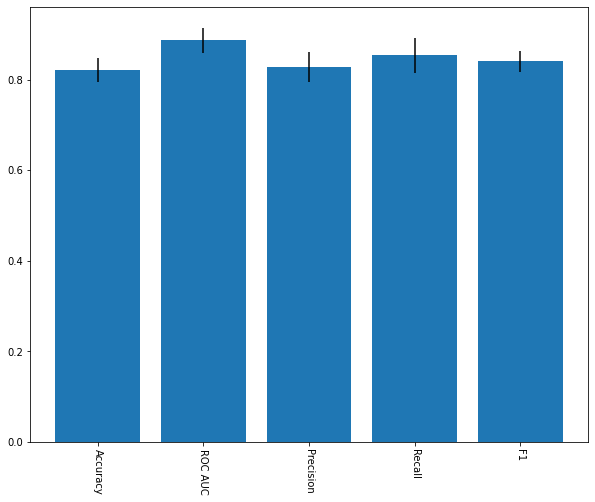

In [4]:
testModel("../input_data/T3PKS_expanded_set.xlsx",'../input_data/T3PKS_embeddings.h5', "../input_data/smiles_combined.csv")

#training_data = readExcel("../input_data/T3PKS_expanded_set.xlsx")
#X_training = makeTrainSet('../input_data/T3PKS_embeddings.h5', "../input_data/smiles_combined.csv", training_data)

In [10]:
#training train and save new "expanded" model
trainModel("../input_data/T3PKS_expanded_set.xlsx",'../input_data/T3PKS_embeddings.h5',
           "../input_data/smiles_combined.csv", "expanded")

Models are already trained
